In [1]:
import sys, os, glob, warnings, logging
import string
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sw_plotting import change_bar_width
from sw_utilities import tukeyTest

logging.basicConfig(stream=sys.stdout, format='%(asctime)s - %(levelname)s - %(message)s', level=logging.ERROR)
# logging.basicConfig(stream=sys.stdout, format='%(asctime)s - %(levelname)s - %(message)s', level=logging.INFO)
# logging.basicConfig(stream=sys.stdout, format='%(asctime)s - %(levelname)s - %(message)s', level=logging.DEBUG)

# ignore warnings
warnings.filterwarnings('ignore')

# plotting configuration
font = {'family' : 'Arial',
        'size'   : 7}
matplotlib.rc('font', **font)
plt.rcParams['svg.fonttype'] = 'none'

# Make a folder if it is not already there to store exported figures
!mkdir ../jupyter_figures


mkdir: ../jupyter_figures: File exists


In [2]:
def layout_to_annotation(plate_id,
                         data_folder='../data/qPCR-data',
                         template_layout_file=None,
                         primer_layout_file=None):
    '''
    '''
    if template_layout_file is None:
        template_layout_files = glob.glob(os.path.join(data_folder, '*'+plate_id+'*template*layout*.csv'))
        assert len(template_layout_files) == 1
        template_layout_file = template_layout_files[0]
    
    if primer_layout_file is None:
        primer_layout_files = glob.glob(os.path.join(data_folder, '*'+plate_id+'*primer*layout*.csv'))
        assert len(primer_layout_files) == 1
        primer_layout_file = primer_layout_files[0]
    
    # Extract template information
    with open(template_layout_file, 'r') as f:
        lines = f.readlines()
    assert lines[0].startswith('template')
    
    template_list = []
    for line in lines[1:]:
        temp = line.strip().split(',')
        assert len(temp) == 13
        template_list = template_list + temp[1:]

    assert len(template_list) == 96
    
    # Extract primer information
    with open(primer_layout_file, 'r') as f:
        lines = f.readlines()
    assert lines[0].startswith('primer')
    
    primer_list = []
    for line in lines[1:]:
        temp = line.strip().split(',')
        assert len(temp) == 13
        primer_list = primer_list + temp[1:]

    assert len(primer_list) == 96
    
    wells = []
    for i in string.ascii_uppercase[:8]:
        for j in range(1,13):
            wells.append(i+'{:02d}'.format(j))
    
    annotation_file = os.path.join(data_folder, plate_id+'-annotation.csv')
    with open(annotation_file, 'w') as f:
        f.write(','.join(['Well', 'Sample', 'Primer']) + '\n')
        for i in range(96):
            f.write(','.join([wells[i], template_list[i], primer_list[i]]) + '\n')

In [3]:
def get_plate_data(plate_id, data_folder='../data/qPCR-data'):
    ''' Given a plate id:
          1. Locate the annotation csv file and the quantification Cq results csv file
          2. Extract useful data, merge and return the data frame
    '''
    layout_to_annotation(plate_id)
    annotation_files = glob.glob(os.path.join(data_folder, '*'+plate_id+'*annotation.csv'))
    assert len(annotation_files) == 1
    annotation_file = annotation_files[0]
    
    exported_csv_folders = glob.glob(os.path.join(data_folder, '*'+plate_id+'*'+os.path.sep))
    assert len(exported_csv_folders) == 1
    exported_csv_folder = exported_csv_folders[0]
    
    data_files = glob.glob(os.path.join(exported_csv_folder, '*Quantification Cq Results.csv'))
    assert len(data_files) == 1
    data_file = data_files[0]
    
    df = pd.read_csv(annotation_file)
    df_annotation = df[['Well', 'Sample', 'Primer']]
    
    df = pd.read_csv(data_file)
    df_data = df[['Well', 'Cq']]
    
    df = df_annotation.merge(df_data, on='Well')
    df.dropna(inplace=True)
    
    return df

def get_expression_data(df, test_primer, ref_primer='Rps29 v1'):
    ''' From the data frame containing qPCR data and annotation, 
        calculate average values of replicates and deltaCq values of each sample
        
    '''
    for i in ['Well', 'Sample', 'Primer', 'Cq']:
        assert i in df.columns
    
    df_ref = df[df.Primer==ref_primer]
    df_ref.rename(columns={'Cq': 'Cq_ref'}, inplace=True)
    
    df_test = df[df.Primer==test_primer]
    df_test.rename(columns={'Cq': 'Cq_test'}, inplace=True)
    
    # calculate average values of technical replicates
    df_ref_mean = df_ref.groupby('Sample').mean()
    df_ref_mean.reset_index(inplace=True)
    
    df_test_mean = df_test.groupby('Sample').mean()
    df_test_mean.reset_index(inplace=True)
    
    df = df_ref_mean.merge(df_test_mean, on='Sample')
    df['deltaCq'] = df.Cq_test - df.Cq_ref
    df['relExp'] = 2**(-df.deltaCq)
    df['Group'] = [df.Sample[i][:-2] for i in range(len(df))]
    
    return df


In [4]:
# Read in data
df_plate1 = get_plate_data('220606-plate1')
df_plate2 = get_plate_data('220606-plate2')
df_plate3 = get_plate_data('220606-plate3')

In [5]:
# Concatenate the data (stacking up and down)
df = pd.concat([df_plate1, df_plate2, df_plate3])
df.reset_index(inplace=True, drop=True)

In [6]:
df

,Well,Sample,Primer,Cq
0,A01,B-188-1,Rps29 v1,22.184486
1,A02,B-188-1,Rps29 v1,22.106597
2,A03,B-188-1,Rps29 v1,21.971934
3,A04,B-317-1,Rps29 v1,21.709593
4,A05,B-317-1,Rps29 v1,21.603098
...,...,...,...,...
175,E08,B-318-5,Itga6 v1,23.346960
176,E09,B-318-5,Itga6 v1,23.280773
177,E10,B-319-5,Itga6 v1,24.645805
178,E11,B-319-5,Itga6 v1,24.777007


In [9]:
df_gene1 = get_expression_data(df, 'Itga3 v1')

In [10]:
df_gene1

,Sample,Cq_ref,Cq_test,deltaCq,relExp,Group
0,B-188-1,22.087673,30.137308,8.049635,0.003774,B-188
1,B-188-2,19.502547,27.625948,8.123401,0.003586,B-188
2,B-188-3,19.237502,27.281748,8.044246,0.003788,B-188
3,B-188-4,20.644886,28.047761,7.402875,0.005909,B-188
4,B-188-5,20.187498,28.664508,8.477010,0.002807,B-188
5,B-317-1,21.692524,30.323398,8.630873,0.002523,B-317
6,B-317-2,19.257319,27.571321,8.314002,0.003142,B-317
7,B-317-3,20.303602,27.154888,6.851287,0.008661,B-317
8,B-317-4,19.985657,27.066783,7.081126,0.007385,B-317
9,B-317-5,19.577181,27.225710,7.648529,0.004984,B-317


<AxesSubplot:xlabel='Group', ylabel='relExp'>

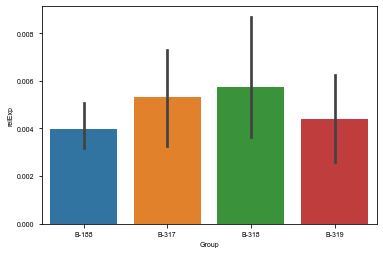

In [12]:
sns.barplot(data=df_gene1, x='Group', y='relExp')

<AxesSubplot:xlabel='Group', ylabel='relExp'>

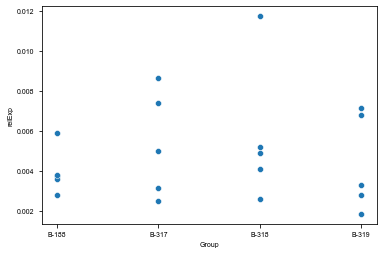

In [13]:
sns.scatterplot(data=df_gene1, x='Group', y='relExp')

In [14]:
df_gene2 = get_expression_data(df, 'Itga6 v1')

In [15]:
df_gene2

,Sample,Cq_ref,Cq_test,deltaCq,relExp,Group
0,B-188-1,22.087673,26.108284,4.020612,0.061613,B-188
1,B-188-2,19.502547,23.701103,4.198556,0.054464,B-188
2,B-188-3,19.237502,23.107661,3.870159,0.068386,B-188
3,B-188-4,20.644886,24.297625,3.652739,0.079509,B-188
4,B-188-5,20.187498,24.187729,4.000231,0.062490,B-188
5,B-317-1,21.692524,25.875536,4.183012,0.055054,B-317
6,B-317-2,19.257319,23.298045,4.040726,0.060760,B-317
7,B-317-3,20.303602,23.629349,3.325748,0.099736,B-317
8,B-317-4,19.985657,23.381478,3.395822,0.095007,B-317
9,B-317-5,19.577181,23.139124,3.561943,0.084674,B-317


<AxesSubplot:xlabel='Group', ylabel='relExp'>

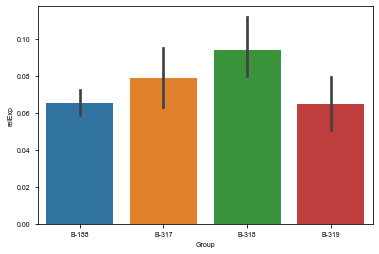

In [16]:
sns.barplot(data=df_gene2, x='Group', y='relExp')

<AxesSubplot:xlabel='Group', ylabel='relExp'>

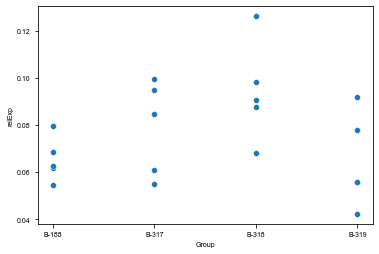

In [17]:
sns.scatterplot(data=df_gene2, x='Group', y='relExp')

In [18]:
tukeyTest(df_gene1.relExp, df_gene1.Group)

Summary of test:
 Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
 B-188  B-317   0.0014  0.819 -0.0033  0.006  False
 B-188  B-318   0.0017 0.6923 -0.0029 0.0064  False
 B-188  B-319   0.0004    0.9 -0.0042 0.0051  False
 B-317  B-318   0.0004    0.9 -0.0043  0.005  False
 B-317  B-319   -0.001    0.9 -0.0056 0.0037  False
 B-318  B-319  -0.0013 0.8298  -0.006 0.0033  False
---------------------------------------------------
p values of all pair-wise tests:
 [0.8189667  0.69230943 0.9        0.9        0.9        0.82980493]


In [19]:
tukeyTest(df_gene2.relExp, df_gene2.Group)

Summary of test:
 Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
 B-188  B-317   0.0138 0.6288 -0.0193 0.0468  False
 B-188  B-318   0.0288 0.0987 -0.0042 0.0619  False
 B-188  B-319  -0.0005    0.9 -0.0336 0.0325  False
 B-317  B-318   0.0151 0.5669  -0.018 0.0481  False
 B-317  B-319  -0.0143 0.6043 -0.0473 0.0188  False
 B-318  B-319  -0.0294 0.0909 -0.0624 0.0037  False
---------------------------------------------------
p values of all pair-wise tests:
 [0.6288147  0.09870922 0.9        0.56687211 0.60429918 0.09085507]
